# Figure 2. Results from iML1515 E. coli model

In [1]:
# imports
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import colormaps as cmaps # for scientific colourmaps

from scipy.interpolate import griddata

## A. Pareto front of iML1515 optimization
* Plots the growth rate on x-axis against medium cost on the y-axis for each candidate medium.
* Each dot is colour-coded according to the batch it resulted from.
* Plots Pareto front deduced from data.
* The performance of the baseline medium is plotted onto the graph to allow for visual performance comparison
* Saves the figure as Figure.png

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_40767/481462519.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["cost"] = data_filtered["cost"] * 1e-3


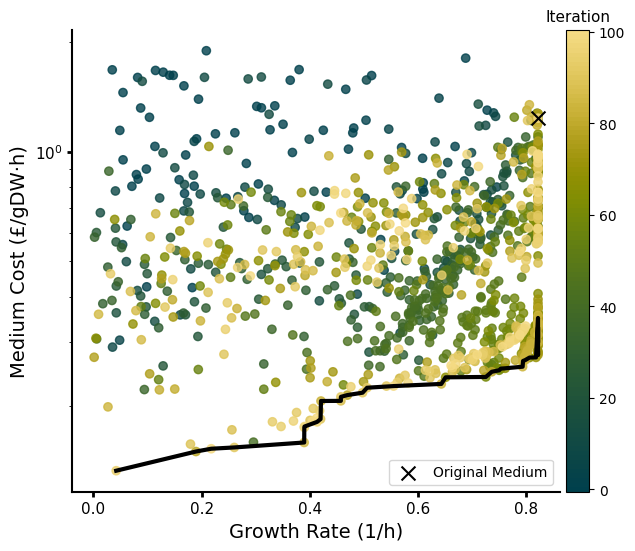

In [9]:
data = pd.read_csv("../data/Figure2AB.csv")

# Create the plot with given size
sf = 1.5
fig, axes = plt.subplots(1, 1, figsize = (5*sf, 4*sf))

# Define colour mapping - 1 for random initial points, 1 each per batch (n_iter)
n_start = data["n_start"][0]
n_batch = data["n_batch"][0]
n_candidates = data["n_candidates"][0]

 # Generate distinct colours
colours = cmaps.bamako.cut(0.05, "right")(np.linspace(0, 1, n_batch + 1))
# Create a custom colourmap for the colour bar
cmap = mcolors.ListedColormap(colours)

# Create an array to store colours for each data point
point_colours = np.zeros(len(data), dtype = object)

# Assign first n_start points the same colour
point_colours[:n_start] = [colours[0]] * n_start
# Assign different colours to each batch
for i in range(n_batch):
    start_idx = n_start + i * n_candidates
    end_idx = start_idx + n_candidates
    point_colours[start_idx:end_idx] = [colours[i + 1]] * (end_idx - start_idx) # Assign a new color per batch

# Set boundaries between each batch, from -0.5 to n_batch + 0.5
boundaries = np.arange(n_batch + 2) - 0.5
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

# filter out all entries where the growth rate is above a certain threshold
data_filtered = data[data["growth_rate"] > 0.001]
# transform cost data from 10^{-3} £/gDW·h to £/gDW·h
data_filtered["cost"] = data_filtered["cost"] * 1e-3
 # Scatter plot with custom colours, applying transparence (alpha = 0.8)
sc = axes.scatter(x = data_filtered["growth_rate"], y = data_filtered["cost"], 
                  c = point_colours[data_filtered.index], alpha = 0.8)
axes.set_yscale("log")


# Extract and sort Pareto points by growth rate
pareto_data = data_filtered[data_filtered["is_pareto"] == True].sort_values(by = "growth_rate")
# Plot as a single line connecting the points
axes.plot(
    pareto_data["growth_rate"],
    pareto_data["cost"],
    color = "black",
    linewidth = 3
)

# plot performance of initial medium
axes.scatter(
    x = data["init_growth_rate"][0],
    y = data["init_cost"][0] * 1e-3,
    color = "black", marker = "x", 
    label = "Original Medium", s = 100, zorder = 5
    )


# axes
axes.set_xlabel("Growth Rate (1/h)", fontsize = 14)
axes.set_ylabel("Medium Cost (£/gDW·h)", fontsize = 14)
axes.xaxis.set_tick_params(width = 2, labelsize = 11)
axes.yaxis.set_tick_params(width = 2, labelsize = 11)
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_linewidth(1.5)
axes.spines["left"].set_linewidth(1.5)

# Add the color bar
tick_positions = np.arange(0, n_batch + 1, 20)
sm = cm.ScalarMappable(cmap = cmap, norm = norm)
cbar = fig.colorbar(sm, ax = axes, ticks = tick_positions, pad = 0.01) # pad defines distance
cbar.ax.set_title("Iteration", fontsize = 11)
cbar.ax.tick_params(which = "minor", size = 0) # turn off minor ticks at colour boundaries
    
# Display the legend with no edge color
axes.legend()
    
# Show the plot
plt.show()
fig.tight_layout()

fig.savefig("../figs/Figure2B.png", dpi = 300, bbox_inches = None)


## B. Bayesian optimization run for iML1515 growth per cost
* Plots growth rate per cost (x-axis) against iteration for each candidate medium
* Plots a line along the best growth-cost trade-off found until a given iteration
* Saves the figure as Figure2A.png

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_40767/3981675103.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = axes.scatter(x = data.index, y = growth_cost_scaled, c = darkteal, alpha = 0.5, s=20)


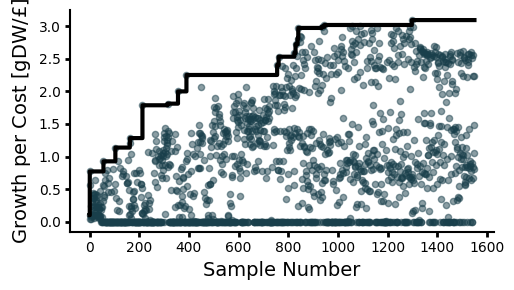

In [8]:
# Read in data
data = pd.read_csv("../data/Figure2AB.csv")
# data = pd.read_csv("Figure2AB.csv")
# Data needs to be scaled by 10^3 to convert from [gDW/(10^-3£) to gdW/£]
growth_cost_scaled = data["growth_cost"]*1e3


sf = 0.75
# Create the plot with given size
fig, axes = plt.subplots(1, 1, figsize = (7*sf, 4*sf))
darkteal = (25/255, 63/255, 75/255)
# Scatter plot with custom colours, applying transparence (alpha = 0.8)
sc = axes.scatter(x = data.index, y = growth_cost_scaled, c = darkteal, alpha = 0.5, s=20)


# draw a line along the best so far result (growth/cost)
best_so_far = -np.inf
best_values = []
for val in growth_cost_scaled:
    if val > best_so_far:
        best_so_far = val
    best_values.append(best_so_far)
axes.step(
    data.index, best_values, where = "post", color = 'black', linestyle = "-",
    linewidth = 3, label = "Best Growth per Cost So Far")

# axes
axes.set_xlabel("Sample Number", fontsize = 14)
axes.set_ylabel("Growth per Cost [gDW/$£$]", fontsize = 14)
axes.xaxis.set_tick_params(width = 2, labelsize = 10)
axes.yaxis.set_tick_params(width = 2, labelsize = 10)
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_linewidth(1.5)
axes.spines["left"].set_linewidth(1.5)

    
fig.tight_layout()
# Show the plot
plt.show()

fig.savefig("../figs/Figure2A.png", dpi = 300, bbox_inches = None)


## C. Creates a scatter plot of MOBO results for two components colored by a growth per cost.
* The x-axis is given by var_1, the y-axis by var_2, the color is given by var_Z.
* results_BO can be the same dataset as results or a different one.
* Saves the figure as png file named *figname + "_" + var_1 + "_" + var_2 + "_" + var_Z +".png"*

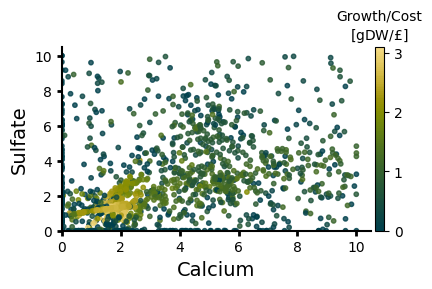

In [7]:
data = pd.read_csv("../data/Figure2C.csv")
# data = pd.read_csv("Figure2C.csv")

# extract chosen medium components as X and Y
var_1 = "EX_ca2_e"
var_2 = "EX_so4_e"
var_1_name = "Calcium"
var_2_name = "Sulfate"
levels = 40

X = data[var_1]
Y = data[var_2]
# Z (the contour) is Growth per Cost or Cost or Growth
# Data needs to be scaled by 10^3 to convert from [gDW/(10^-3£) to gdW/£]
Z = data["growth_cost"]*1e3

# Create figure and axis
sf = 0.75
fig, axes = plt.subplots(figsize = (6*sf, 4*sf))

"""
INSERT PLOTTING THE DATA POINTS
"""

# Generate 100 colours linearly from 0 → max growth_cost
Z_min, Z_max = 0, Z.max()
colours = cmaps.bamako.cut(0.05, "right")(np.linspace(0, 1, 100))
cmap = mcolors.ListedColormap(colours)

# Normalise growth_cost values into [0,1] range
norm = mcolors.Normalize(vmin=Z_min, vmax=Z_max)


sc = axes.scatter(
    x = X, y = Y, c = Z, 
    alpha = 0.8, s = 10, label = "BO Samples", cmap = cmap
    )

# Add the color bar & define ticks
tick_positions_BO = np.arange(0, n_batch + 1, 5)
sm = cm.ScalarMappable(cmap = cmap, norm = norm)
cbar_BO = fig.colorbar(sm, ax = axes, pad = 0.01)
cbar_BO.ax.set_title("Growth/Cost\n[gDW/$£$]", fontsize = 10)
cbar_BO.ax.tick_params(which = 'minor', size = 0) # turn off minor ticks at colour boundaries       


# axes
axes.set_ylim(0, Y.max() * 1.05)
axes.set_xlim(0, X.max() * 1.05)
axes.set_xlabel(var_1_name, fontsize = 14)
axes.set_ylabel(var_2_name, fontsize = 14)
axes.xaxis.set_tick_params(width = 2, labelsize = 10)
axes.yaxis.set_tick_params(width = 2, labelsize = 10)
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_linewidth(1.5)
axes.spines["left"].set_linewidth(1.5)

# Display the legend
# axes.legend()
    
# Show the plot
fig.tight_layout()
plt.show()

fig.savefig("../figs/Figure2C.png", dpi = 300, bbox_inches = None)
plt.close(fig)